Notes
 - estimating the noise. Best to use measurements against g-t. Using a histogram loses the order and discretizes the data so not the best estiumate of the error
  - 3.1 objective is the sum of squares error

v2 script
 - betaGT is 2 element array, with beta[0] having slope, and beta[1] the interecept
 - J is the interecept array of only 1s in a single column, X is the design matrix of [J; x]

Uncertainty
 - In virtual environment we can do better than bootstrap. We can just generate new data N times. This gives the best estimate of uncertainty we can get for our parameters (slope, intercept) -> we expect the distribution of each parameter to be Gaussian
    - This is because if y is gaussian distirbuted -> multiple, addition, etc. is also gaussian.
    - different parameters have different var because they have different operations on them so can work out what their expected var should be
    - NOTE: the var estimate of data is NOT gaussian. It is Chi-squared distributed

Variable Space
 - 1 axis for each variable
 
Subject Space
 - 1 axis for each observation. So N observations we are in a R^N space
 - Each point represents all observations for that variable (so an arrow for each variable)
 - solution space is the hyper-plane created by using the bias arrow, and the arrows for predictor arrows. The outcome arrow stays in this hyper-plane (solution space) if there is no noise -> indicates the model describes the data perfectly#
 - the least Squares solution will find the solution that gives the smallest distance between the solution space and the outcome arrow
 - error space is orthogonal to the solution space. We can tell apart the noise from the model for any error in the error space. dim of error space is n-p where n is number of measurements and we have p parameters. Any error in error space will be seen as error, and not incorporated in the model
  - estimation space is error within the solution space which we can't tell apart from the model. This is because the model will interpret the error as true signal
  - We want as many measurements as possible to get the error space to be much higher dim than the estimation space which will reduce the variance of our model

How do we know slope/beta is zero?
 - Use the null hypothesis of beta being zero, and find the p-value of it not being zero
 - how do we do this if we don't know the underlying noise? We can use permutation test which doesn't make strong assumptions on the noise

In [132]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=22197823)

# q1.a

Data 1: mean : 1.50, std: 0.19. Expected mean and std: 1.5, 0.2
Data 2: mean : 1.94, std: 0.20. Expected mean and std: 2.0, 0.2


Text(0.5, 1.0, 'Synthetic data 1 vs 2')

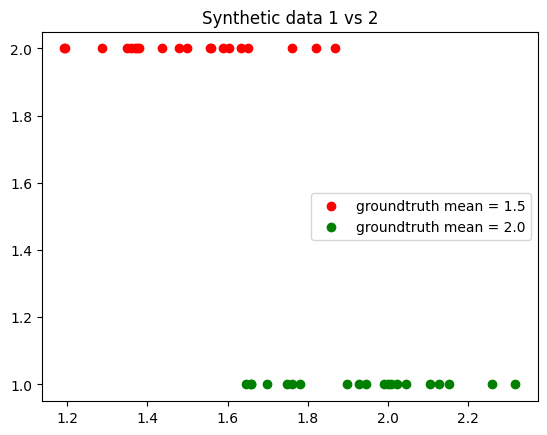

In [133]:
# generate sample data
std_gt = 0.2
mean_1_gt = 1.5
mean_2_gt = 2.0
N = 20

group1 = rng.normal(loc=mean_1_gt, scale=std_gt, size=N)
group2 = rng.normal(loc=mean_2_gt, scale=std_gt, size=N)

mean_1_calc = group1.mean()
mean_2_calc = group2.mean()
std_1_calc = group1.std()
std_2_calc = group2.std()

print(f'Data 1: mean : {mean_1_calc:.02f}, std: {std_1_calc:.02f}. Expected mean and std: {mean_1_gt}, {std_gt}')
print(f'Data 2: mean : {mean_2_calc:.02f}, std: {std_2_calc:.02f}. Expected mean and std: {mean_2_gt}, {std_gt}')

plt.scatter(group1, 2 * np.ones(N), color='r', label=f'groundtruth mean = {mean_1_gt}')
plt.scatter(group2, 1 * np.ones(N), color='g', label=f'groundtruth mean = {mean_2_gt}')
plt.legend()
plt.title('Synthetic data 1 vs 2')

# q1.b

In [134]:

t_statistic_gt, p_val = stats.ttest_ind(group1, group2)
print(f'T statistic: {t_statistic_gt:.2f}, p-value: {p_val:.10f}')

T statistic: -7.04, p-value: 0.0000000215


# q1.c i)

In [135]:
# for Y = X1 * B1 + X2 * B2 + e, what is the design matrix?
# synthetic data is from 2 groups

# design matrix:
X = np.zeros(shape=(40,2))
X[:20, 0] = 1
X[20:, 1] = 1

Y = np.hstack([group1, group2])

rank = np.linalg.matrix_rank(X)
print(f'rank of C(X) = {rank}')

rank of C(X) = 2


# q1.c ii)

In [136]:
Px = X @ np.linalg.inv(X.T @ X) @ X.T
print(f'Trace(Px) = {np.trace(Px):.2f}')

Trace(Px) = 2.00


# q1.c iii)

In [137]:
# use Px to find Y_hat
Y_hat = Px @ Y
print(f'error between Y and Y_hat: {(Y - Y_hat).sum():.2f}')

error between Y and Y_hat: -0.00


In [138]:
X.shape

(40, 2)

# q1.c iv)

In [139]:
d = Px.shape[0]
Rx = np.identity(d) - Px

eps = 1e-9

if np.abs((Rx @ Rx - Rx).sum()) < eps and np.abs((Rx - Rx.T).sum()) < eps:
    print(f'Rx = (I - Px) has passed numerical tests for being a perpendicular projection operator')
else:
    print(f'Rx FAILED a numerical test for being a perpendicular projection operator')

Rx = (I - Px) has passed numerical tests for being a perpendicular projection operator


# q1.c v)

In [140]:
error_hat = Rx @ Y
error_hat

error_space_dim = np.linalg.matrix_rank(Rx)

print(f'error space dim: {error_space_dim}')

error space dim: 38


# q1.c vi)

In [141]:
# normalise the vectors then calc the angle
divisor = np.sqrt(np.dot(error_hat, error_hat) * np.dot(Y_hat, Y_hat))
numerator = np.dot(error_hat, Y_hat)
angle = np.arccos(numerator / divisor) / np.pi

print(f'angle between Y_hat and error_hat is {angle:.2f} * pi')
print(f'we expect error_hat and Y_hat to be perpendicular, so the angle should be 0.5 * pi')

angle between Y_hat and error_hat is 0.50 * pi
we expect error_hat and Y_hat to be perpendicular, so the angle should be 0.5 * pi


# q1.c vii)

In [142]:
M = np.linalg.inv(X.T @ X)
beta = M @ X.T @ Y
Y_hat_1 = X @ beta
diff = Y_hat - Y_hat_1
print(f'Difference when calculating Y_hat using Y = X @ Beta: {diff.sum():.2f}')

Difference when calculating Y_hat using Y = X @ Beta: 0.00


# q1.c viii)

In [143]:
numerator = np.dot(error_hat, error_hat)
n = X.shape[0]
divisor = n - np.linalg.matrix_rank(X)
var_hat = numerator / divisor
var_hat

0.0390570392238516

# q1.c ix)

In [144]:
S_beta = var_hat * np.linalg.inv(X.T @ X)
std_beta1 = np.sqrt(S_beta[0,0])
std_beta2 = np.sqrt(S_beta[1,1])

print(f'standard deviation for Beta_1 : {std_beta1:.2f}, for Beta_2 : {std_beta2:.2f}')

standard deviation for Beta_1 : 0.04, for Beta_2 : 0.04


# q1.c x)

In [145]:
# calculate the contrast vector lmbda and the reduced model X_0

lmbda = np.asarray([1, -1])
X_0 = X @ np.asarray([1, 1])
X_0 = X_0.reshape((-1,1))

# q1.c xi)

In [146]:
# calculate the error from the reduced model

Px_0 = X_0 @ np.linalg.inv(X_0.T @ X_0) @ X_0.T
d = Px_0.shape[0]
I = np.identity(d)
Rx_0 = (I - Px_0)
error_0_hat = Rx_0 @ Y

# SSR = sum(Y_mean - Y_hat)**2
# we have error = Y - Y_hat -> so introduce Y_error = Y_mean - Y
v1 = np.trace(Px - Px_0)
v2 = np.trace(I - Px)
Y_error = Y.mean() - Y
SSR_X0 = np.square(Y_error + error_0_hat).sum()
SSR_X = np.square(Y_error + error_hat).sum()

F_numerator = (SSR_X0 - SSR_X) / v1
F_denominator = SSR_X / v2

F_statistic = F_numerator / F_denominator
print(f'F statistic comparing the reduced model to the full model: {F_statistic:.2f}')

print('the degrees of freedom of the F statistic is')

F statistic comparing the reduced model to the full model: -38.00
the degrees of freedom of the F statistic is


# q1.c xii)

In [147]:
# calculate the t-statistic

numerator = lmbda @ beta
denominator = np.sqrt(lmbda.reshape((1,-1)) @ S_beta @ lmbda.reshape((-1,1)))[0,0]
t_statistic = numerator / denominator
print(f't-statistic for different means: {t_statistic:.2f}')
print(f'difference between t-statistic calculated at the begining : {t_statistic - t_statistic_gt:.5f}')

t-statistic for different means: -7.04
difference between t-statistic calculated at the begining : 0.00000


# q1.c xiii)

In [148]:
# calcualte error from ground truth (Y_gt)
Y_gt = np.ones(Y.shape[0])
Y_gt[:20] = 1.5
Y_gt[20:] = 2.0

error = Y_gt - Y
error_projected_CX = Px @ error
error_projected_CX

array([0.00218045, 0.00218045, 0.00218045, 0.00218045, 0.00218045,
       0.00218045, 0.00218045, 0.00218045, 0.00218045, 0.00218045,
       0.00218045, 0.00218045, 0.00218045, 0.00218045, 0.00218045,
       0.00218045, 0.00218045, 0.00218045, 0.00218045, 0.00218045,
       0.06202232, 0.06202232, 0.06202232, 0.06202232, 0.06202232,
       0.06202232, 0.06202232, 0.06202232, 0.06202232, 0.06202232,
       0.06202232, 0.06202232, 0.06202232, 0.06202232, 0.06202232,
       0.06202232, 0.06202232, 0.06202232, 0.06202232, 0.06202232])

# q1.c xv)

In [149]:
# error projected into not(C(x))

error_projected_not_CX = Rx @ error
error_projected_not_CX

print(f'error_hat diff to this: {error_hat + error_projected_not_CX}')

error_hat diff to this: [-3.33066907e-16 -5.55111512e-16 -3.46944695e-16 -2.45463372e-16
 -4.02455846e-16 -2.77555756e-16 -1.66533454e-16 -2.49800181e-16
 -1.52655666e-16 -2.77555756e-17 -2.22044605e-16 -2.49800181e-16
 -1.66533454e-16 -2.46330734e-16 -2.49800181e-16 -1.11022302e-16
 -1.66533454e-16 -1.66533454e-16 -1.66533454e-16 -2.49800181e-16
 -5.55111512e-17 -2.49800181e-16 -5.55111512e-17  2.77555756e-16
 -2.77555756e-17 -4.59701721e-17 -1.11022302e-16 -1.66533454e-16
 -2.70616862e-16 -2.67147415e-16 -4.16333634e-17 -2.77555756e-16
 -2.77555756e-16 -2.49800181e-16 -5.55111512e-16 -4.99600361e-16
 -4.85722573e-16 -2.77555756e-16 -2.70616862e-16 -3.88578059e-16]


# q1.d i)

In [150]:
X_intercept = np.zeros(shape=(Y.shape[0], 3))
X_intercept[:,   0] = 1
X_intercept[:20, 1] = 1
X_intercept[20:, 2] = 1

print(f'design matrix X has rank {np.linalg.matrix_rank(X_intercept)}')

design matrix X has rank 2


# q1.d ii)

In [151]:
Z = X_intercept
Px_intercept = Z @ np.linalg.pinv(Z.T @ Z) @ Z.T
Px_intercept

array([[ 5.00000000e-02,  5.00000000e-02,  5.00000000e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-02,  5.00000000e-02,  5.00000000e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-02,  5.00000000e-02,  5.00000000e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.46944695e-18, -3.46944695e-18, -3.46944695e-18, ...,
         5.00000000e-02,  5.00000000e-02,  5.00000000e-02],
       [-3.46944695e-18, -3.46944695e-18, -3.46944695e-18, ...,
         5.00000000e-02,  5.00000000e-02,  5.00000000e-02],
       [-3.46944695e-18, -3.46944695e-18, -3.46944695e-18, ...,
         5.00000000e-02,  5.00000000e-02,  5.00000000e-02]])

# q1.d iii)

In [152]:
lmbda_intercept = np.asarray([0,1,-1]).reshape((1,-1))
mult = np.asarray([[1, 0],
                   [0, 1],
                   [0, 1]])
X_0_intercept = X_intercept @ mult
X_0_intercept.shape

(40, 2)

# q1.d iv)

In [153]:
# calculate the t-statistic

d = Y.shape[0]
I = np.identity(d)
Rx_intercept = (I - Px_intercept)
error_hat_intercept = Rx_intercept @ Y
M = np.linalg.pinv(X_intercept.T @ X_intercept)
beta_intercept = M @ X_intercept.T @ Y

numerator = (np.dot(error_hat_intercept, error_hat_intercept))
denominator = d - np.linalg.matrix_rank(X_intercept)
var_hat_intercept = numerator / denominator

S_beta_intercept = var_hat_intercept * M

numerator = lmbda_intercept @ beta_intercept
denominator = np.sqrt(lmbda_intercept @ S_beta_intercept @ lmbda_intercept.T)
t_statistic_intercept = (numerator / denominator)[0,0]
t_statistic_intercept

-7.043022482674422

# q1.e i)

In [154]:
X_e= np.zeros(shape=(Y.shape[0], 2))
X_e[:,   0] = 1
X_e[:20, 1] = 1

print(f'design matrix X has rank {np.linalg.matrix_rank(X_d)}')

design matrix X has rank 2


# q1.e ii)

In [155]:
lmbda_e = np.asarray([0, 1]).reshape((2, -1))

# q1.e iii)

In [156]:
# calculate the t-statistic
Z = X_e
Px_e = Z @ np.linalg.pinv(Z.T @ Z) @ Z.T
Px_e

d = Y.shape[0]
I = np.identity(d)
Rx_e = (I - Px_e)
error_hat_e = Rx_e @ Y
M = np.linalg.pinv(X_e.T @ X_e)
beta_e = M @ X_e.T @ Y

numerator = (np.dot(error_hat_e, error_hat_e))
denominator = d - np.linalg.matrix_rank(X_e)
var_hat_e = numerator / denominator

S_beta_e = var_hat_e * M

numerator = np.dot(lmbda_e.flatten(), beta_e)
denominator = np.sqrt(lmbda_e.T @ S_beta_e @ lmbda_e)
t_statistic_e = (numerator / denominator)[0,0]
t_statistic_e

-7.043022482674419

 # q2.a i)

In [211]:
# now computing the ttest for null hypothesis 2 samples come from the same
# distribution with the same mean
t_statistic_1sample, p_val_1sample = stats.ttest_rel(group1, group2)
print(f'ttest for 1 sample distribution: t = {t_statistic_1sample:.2f}, p-value = {p_val_1sample:.8f}')
print(f'ttest for 2 sample distribution: t = {t_statistic:.2f}, p-value = {p_val:.8f}')

ttest for 1 sample distribution: t = -6.13, p-value = 0.00000678
ttest for 2 sample distribution: t = -7.04, p-value = 0.00000002


# q2.b i)

In [199]:
# create the design matrix
X_2b = np.zeros(shape=(40,22))
X_2b[:,   0] = 1
X_2b[20:, 1] = 1
for i in range(20):
    X_2b[i,    i+2] = 1
    X_2b[20+i, i+2] = 1

print(f'rank of X is: {np.linalg.matrix_rank(X_2b)}')

rank of X is: 21


In [208]:
# create lmbda
lmbda_2b = np.zeros(22)
lmbda_2b[1] = -1
lmbda_2b = lmbda_2b.reshape((22,1))

# q2.b iii)

In [209]:
# calculate the t-statistic
Z = X_2b
Px_2b = Z @ np.linalg.pinv(Z.T @ Z) @ Z.T
Px_2b

d = Y.shape[0]
I = np.identity(d)
Rx_2b = (I - Px_2b)
error_hat_2b = Rx_2b @ Y
M = np.linalg.pinv(X_2b.T @ X_2b)
beta_2b = M @ X_2b.T @ Y

numerator = (np.dot(error_hat_2b, error_hat_2b))
denominator = d - np.linalg.matrix_rank(X_2b)
var_hat_2b = numerator / denominator

S_beta_2b = var_hat_2b * M

numerator = np.dot(lmbda_2b.flatten(), beta_2b)
denominator = np.sqrt(lmbda_2b.T @ S_beta_2b @ lmbda_2b)
t_statistic_2b = (numerator / denominator)[0,0]
t_statistic_2b

-6.132546581166477